Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd

from joblib import dump, load

from gamechanger import mdn_loss, MDNNetwork, TyreDegDataset

from datetime import datetime

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [2]:
cotaData = pd.read_csv(r"C:\Users\lordw\OneDrive\Documents\ML\MLprojects\F1hackTx\backend\data\mercedes_cota_2022_2024.csv")
cotaData.columns

Index(['timestamp', 'season', 'driver', 'lap_number', 'position',
       'interval_gap', 'flag_status', 'incident_message', 'lap_time',
       'push_signal', 'tyre_compound', 'stint_lap_count', 'tyre_wear_pct',
       'tyre_temp_C', 'engine_power_pct', 'throttle_pct', 'speed_kph',
       'drs_status', 'weather_condition', 'rainfall_mm', 'air_temperature_C',
       'fuel_load_kg'],
      dtype='object')

In [3]:
cotaData['push_signal'].unique()

array(['MAINTAIN', 'PUSH', 'CONSERVE', 'DEGRADATION WARNING'],
      dtype=object)

In [4]:
filtered_data = cotaData

feature_cols = [col for col in filtered_data.columns 
                if col not in ["timestamp", "driver", "flag_status", "push_signal",
                               "tyre_compound", "drs_status", "weather_condition", "lap_time"]]

# Apply z-score normalization
filtered_data[feature_cols] = (
    filtered_data[feature_cols] - filtered_data[feature_cols].mean()
) / filtered_data[feature_cols].std()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [5]:
dataset = TyreDegDataset(data=cotaData, seq_len=10)

In [39]:
dataset = TyreDegDataset(data=cotaData, seq_len=10)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([64, 10, 14]) torch.Size([64])


In [40]:
seq_len = 10
num_features = filtered_data.shape[1] - len(['timestamp','driver','flag_status','push_signal','tyre_compound','drs_status','weather_condition','lap_time'])
in_dim = seq_len * num_features
action_dim = 4  # your 'MAINTAIN', 'PUSH', 'CONSERVE'
out_dim = 1     # predicting lap_time
latent_dim = 64
print(seq_len)
print(num_features)
print(in_dim)
print(action_dim)
print(out_dim)
print(latent_dim)
model = MDNNetwork(in_dim=in_dim, action_dim=action_dim, latent_dim=latent_dim, out_dim=out_dim)

10
14
140
4
1
64


In [41]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [42]:
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.view(X_batch.size(0), -1)
y_batch = y_batch.view(-1, 1)
mu, sigma, pi = model(X_batch)
print(mu.shape, sigma.shape, pi.shape, y_batch.shape)

torch.Size([64, 4, 1]) torch.Size([64, 4, 1]) torch.Size([64, 4]) torch.Size([64, 1])


In [43]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.view(X_batch.size(0), -1)  # flatten
        y_batch = y_batch.view(-1, 1)                # ensure [B, 1]

        mu, sigma, pi = model(X_batch)
        loss = mdn_loss(y_batch, mu, sigma, pi)

        loss.backward()
        optimizer.step()

        
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/100, Train Loss: 14.3628
Epoch 2/100, Train Loss: 10.0540
Epoch 3/100, Train Loss: 8.4246
Epoch 4/100, Train Loss: 7.6349
Epoch 5/100, Train Loss: 7.1845
Epoch 6/100, Train Loss: 6.9018
Epoch 7/100, Train Loss: 6.7102
Epoch 8/100, Train Loss: 6.5693
Epoch 9/100, Train Loss: 6.4592
Epoch 10/100, Train Loss: 6.3691
Epoch 11/100, Train Loss: 6.2927
Epoch 12/100, Train Loss: 6.2259
Epoch 13/100, Train Loss: 6.1660
Epoch 14/100, Train Loss: 6.1115
Epoch 15/100, Train Loss: 6.0609
Epoch 16/100, Train Loss: 6.0136
Epoch 17/100, Train Loss: 5.9689
Epoch 18/100, Train Loss: 5.9263
Epoch 19/100, Train Loss: 5.8854
Epoch 20/100, Train Loss: 5.8458
Epoch 21/100, Train Loss: 5.8073
Epoch 22/100, Train Loss: 5.7697
Epoch 23/100, Train Loss: 5.7328
Epoch 24/100, Train Loss: 5.6972
Epoch 25/100, Train Loss: 5.6633
Epoch 26/100, Train Loss: 5.6299
Epoch 27/100, Train Loss: 5.5958
Epoch 28/100, Train Loss: 5.5611
Epoch 29/100, Train Loss: 5.5261
Epoch 30/100, Train Loss: 5.4907
Epoch 31/100, Tra

In [44]:
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        # reshape target
        y_batch = y_batch.view(-1, 1)
        
        mu, sigma, pi = model(X_batch)
        loss = mdn_loss(y_batch, mu, sigma, pi)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 3.1958


In [45]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import torch

def plot_mdn_batch(model, X_batch, batch_labels=None, separate=True, zoom=3):
    """
    Plot MDN predicted Gaussian mixtures for a batch.
    
    Args:
        model: trained MDN model
        X_batch: [B, seq_len, feature_dim] tensor
        batch_labels: optional, true target values
        separate: if True, plot each Gaussian component in separate subplots
        zoom: how many std devs around the mean to visualize
    """
    model.eval()
    B = X_batch.size(0)
    
    # Flatten sequence for MDN input
    X_batch_flat = X_batch.view(B, -1)
    
    with torch.no_grad():
        mu, sigma, pi = model(X_batch_flat)  # mu/sigma: [B, K, 1], pi: [B, K]
    
    K = mu.shape[1]
    
    for b in range(B):
        mu_b = mu[b, :, 0].cpu().numpy()
        sigma_b = sigma[b, :, 0].cpu().numpy()
        pi_b = pi[b, :].cpu().numpy()

        # Focus x-range around component means
        x_min = mu_b.min() - zoom * sigma_b.max()
        x_max = mu_b.max() + zoom * sigma_b.max()
        x = np.linspace(x_min, x_max, 1000)
        
        # --- Single combined mixture view ---
        if not separate:
            y_total = np.zeros_like(x)
            plt.figure(figsize=(7, 4))
            
            for k in range(K):
                y_k = pi_b[k] * norm.pdf(x, mu_b[k], sigma_b[k])
                y_total += y_k
                plt.plot(x, y_k, linestyle='--', label=f'Gaussian {k+1}')
            
            plt.plot(x, y_total, color='black', linewidth=2, label='Mixture')
            
            if batch_labels is not None:
                plt.axvline(batch_labels[b].item(), color='red', linestyle=':', label='True Value')
            
            plt.title(f"Sample {b+1} - MDN Predicted Mixture")
            plt.xlabel("lap_time")
            plt.ylabel("Probability Density")
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # --- Separate component views ---
        else:
            fig, axes = plt.subplots(K, 1, figsize=(7, 2.5 * K), sharex=True)
            y_total = np.zeros_like(x)
            
            for k in range(K):
                y_k = pi_b[k] * norm.pdf(x, mu_b[k], sigma_b[k])
                y_total += y_k
                axes[k].plot(x, y_k, '--', label=f'Gaussian {k+1}')
                axes[k].legend()
                axes[k].grid(True)
            
            # Optional: plot mixture at the bottom
            axes[-1].plot(x, y_total, color='black', linewidth=2, label='Mixture')
            if batch_labels is not None:
                axes[-1].axvline(batch_labels[b].item(), color='red', linestyle=':', label='True Value')
                axes[-1].legend()
            
            plt.suptitle(f"Sample {b+1} - MDN Component Breakdown", y=0.92)
            axes[-1].set_xlabel("lap_time")
            plt.tight_layout()
            plt.show()


In [46]:
torch.save(model.state_dict(), "mdn_model_4_nt.pth")

In [47]:
cotaData['timestamp'] = pd.to_datetime(cotaData['timestamp'])
cotaData = cotaData.sort_values('timestamp').reset_index(drop=True)

In [48]:
seq_len = 10
num_features = 14
in_dim = seq_len * num_features
action_dim = 4
out_dim = 1
latent_dim = 64

# Load model
model = MDNNetwork(in_dim=in_dim, action_dim=action_dim, latent_dim=latent_dim, out_dim=out_dim)
model.load_state_dict(torch.load(r"mdn_model_4_nt.pth", map_location="cpu"))
model.eval()

MDNNetwork(
  (net): Sequential(
    (0): Linear(in_features=140, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=4, bias=True)
  (fc_sigma): Linear(in_features=64, out_features=4, bias=True)
  (fc_pi): Linear(in_features=64, out_features=4, bias=True)
)

In [55]:
def plot_mdn_batch(model, X_batch, y_true=None, target_name="lap_time", zoom=3):
    model.eval()
    with torch.no_grad():
        if X_batch.ndim == 3:
            B = X_batch.size(0)
            X_in = X_batch.view(B, -1)
        else:
            X_in = X_batch
            B = X_in.size(0)

        mu, sigma, pi = model(X_in)
        K = mu.shape[1]

    for b in range(B):
        mu_b = mu[b, :, 0].cpu().numpy()
        sigma_b = sigma[b, :, 0].cpu().numpy()
        pi_b = pi[b, :].cpu().numpy()

        # Define plotting range based on ALL components
        # Include components even with low weights
        x_min = mu_b.min() - zoom * sigma_b.max()
        x_max = mu_b.max() + zoom * sigma_b.max()
        x = np.linspace(x_min, x_max, 1000)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # LEFT PLOT: Weighted components (what you had)
        ax1 = axes[0]
        for k in range(K):
            y_k = pi_b[k] * norm.pdf(x, mu_b[k], sigma_b[k])
            ax1.plot(x, y_k, linestyle='--', label=f'G{k+1} (π={pi_b[k]:.3f})')
        
        # Add mixture density
        mixture_density = np.zeros_like(x)
        for k in range(K):
            mixture_density += pi_b[k] * norm.pdf(x, mu_b[k], sigma_b[k])
        ax1.plot(x, mixture_density, 'k-', linewidth=2, label='Mixture', alpha=0.7)
        
        if y_true is not None:
            true_val = y_true[b].item()
            ax1.axvline(true_val, color='red', linestyle=':', linewidth=2, label='True Value')
        
        ax1.set_title(f"Sample {b+1} - Weighted Components")
        ax1.set_xlabel(target_name)
        ax1.set_ylabel("Weighted Density")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # RIGHT PLOT: Unweighted components (to see all components clearly)
        ax2 = axes[1]
        for k in range(K):
            # Plot WITHOUT weighting to see all components
            y_k = norm.pdf(x, mu_b[k], sigma_b[k])
            ax2.plot(x, y_k, linestyle='--', 
                    label=f'G{k+1}: μ={mu_b[k]:.1f}, σ={sigma_b[k]:.1f}, π={pi_b[k]:.3f}')
        
        if y_true is not None:
            true_val = y_true[b].item()
            ax2.axvline(true_val, color='red', linestyle=':', linewidth=2, label='True Value')
        
        ax2.set_title(f"Sample {b+1} - Unweighted Components")
        ax2.set_xlabel(target_name)
        ax2.set_ylabel("Unweighted Density")
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print debug info
        print(f"\nSample {b+1} Debug:")
        print(f"Means: {mu_b}")
        print(f"Sigmas: {sigma_b}")
        print(f"Weights: {pi_b}")

In [56]:
print(cotaData['lap_time'].describe())

count    336.000000
mean      98.062851
std        7.454737
min       89.266000
25%       94.263750
50%       96.054500
75%       98.584750
max      134.879000
Name: lap_time, dtype: float64


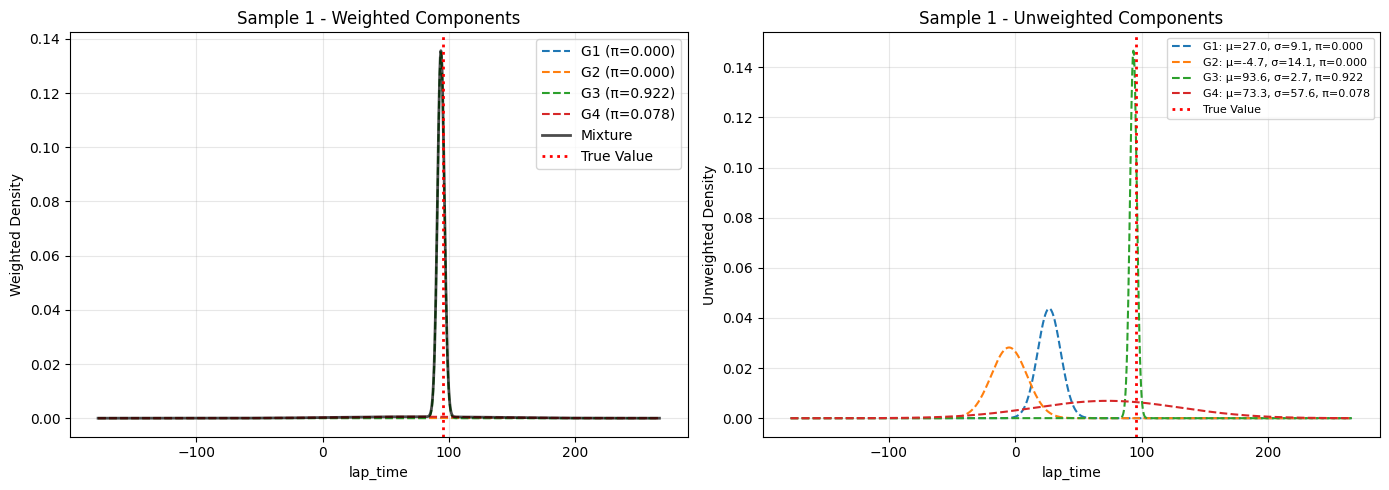


Sample 1 Debug:
Means: [27.007135  -4.7055945 93.63307   73.26127  ]
Sigmas: [ 9.117167  14.138875   2.7200668 57.578518 ]
Weights: [4.09538941e-18 1.15748036e-10 9.21500504e-01 7.84994513e-02]


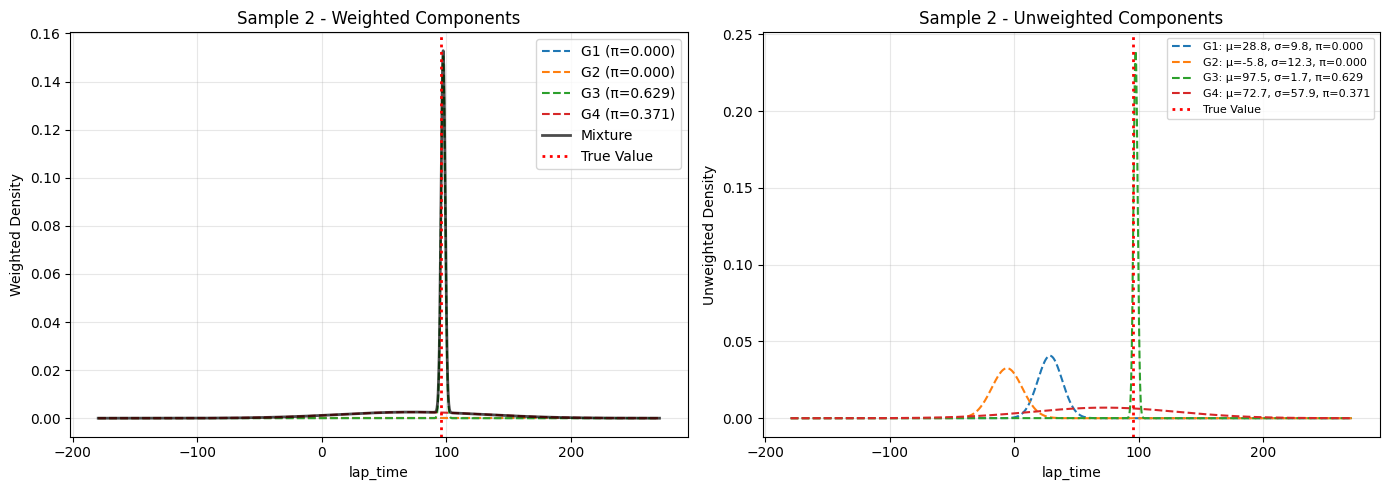


Sample 2 Debug:
Means: [28.782488  -5.7598433 97.490074  72.704704 ]
Sigmas: [ 9.811173 12.255083  1.666652 57.90782 ]
Weights: [6.3623945e-18 3.0058014e-10 6.2879169e-01 3.7120831e-01]


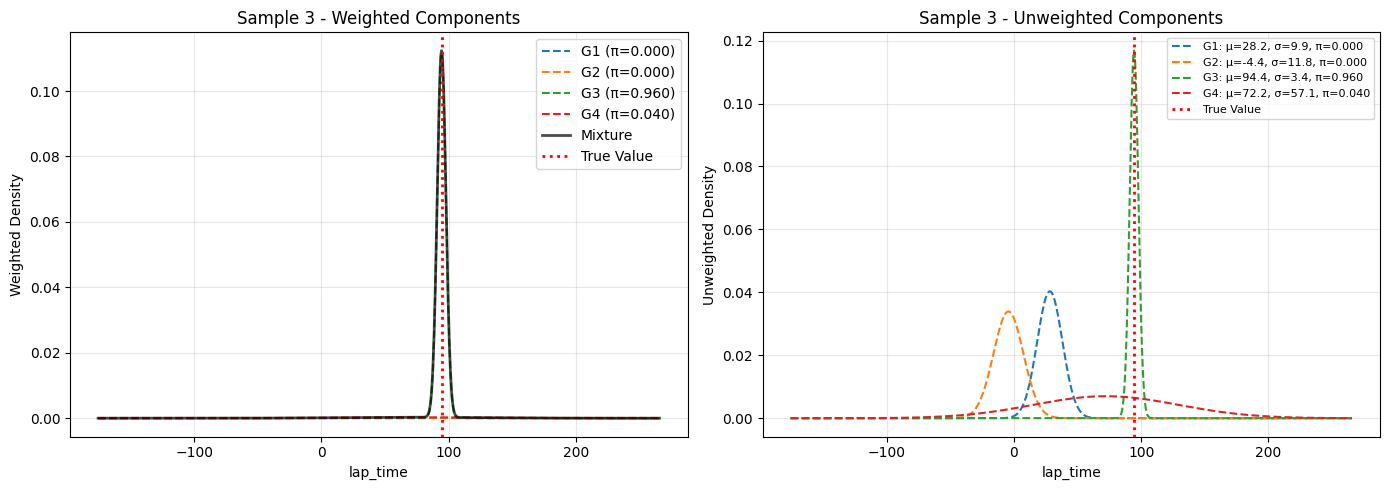


Sample 3 Debug:
Means: [28.166773 -4.359246 94.382065 72.22907 ]
Sigmas: [ 9.89554   11.763118   3.4138288 57.080402 ]
Weights: [3.5424804e-18 3.8583584e-11 9.5964301e-01 4.0357035e-02]


In [57]:
X_test, y_test = next(iter(test_loader))
plot_mdn_batch(model, X_test[:3], y_true=y_test[:3], target_name="lap_time", zoom=3)

In [ ]:
# Save the model
dump(model, 'logistic_model.joblib')

['logistic_model.joblib']